In [44]:
import pandas as pd
import numpy as np
from matplotlib import pyplot 
import seaborn as sns
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, Normalizer, StandardScaler
from sklearn import tree, neighbors, metrics, ensemble
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.decomposition import PCA
from sklearn.ensemble import VotingClassifier

In [3]:
df_train= pd.read_csv('LFTS_train/train.csv')
df_test= pd.read_csv('LFTS_test.csv')

In [4]:
df_train['Employment.Type'].fillna(df_train['Employment.Type'].dropna().max(), inplace=True)
df_test['Employment.Type'].fillna(df_test['Employment.Type'].dropna().max(), inplace=True)

In [5]:
train=df_train.drop(['UniqueID','Date.of.Birth','DisbursalDate','AVERAGE.ACCT.AGE','CREDIT.HISTORY.LENGTH','branch_id','supplier_id', 'manufacturer_id', 'Current_pincode_ID','State_ID','Employee_code_ID'], axis=1)
test=df_test.drop(['UniqueID','Date.of.Birth','DisbursalDate','AVERAGE.ACCT.AGE','CREDIT.HISTORY.LENGTH','branch_id','supplier_id', 'manufacturer_id', 'Current_pincode_ID','State_ID','Employee_code_ID'], axis=1)

In [6]:
train.head()

,disbursed_amount,asset_cost,ltv,Employment.Type,MobileNo_Avl_Flag,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,Passport_flag,...,SEC.OVERDUE.ACCTS,SEC.CURRENT.BALANCE,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,NO.OF_INQUIRIES,loan_default
0,50578,58400,89.55,Salaried,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,47145,65550,73.23,Self employed,1,1,0,0,0,0,...,0,0,0,0,1991,0,0,1,0,1
2,53278,61360,89.63,Self employed,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,57513,66113,88.48,Self employed,1,1,0,0,0,0,...,0,0,0,0,31,0,0,0,1,1
4,52378,60300,88.39,Self employed,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1


In [7]:
le=LabelEncoder()
col=['PERFORM_CNS.SCORE.DESCRIPTION', 'Employment.Type']
for c in col:
    train[c]=le.fit_transform(train[c])
    test[c]=le.fit_transform(test[c])

0: 182543
1: 50611


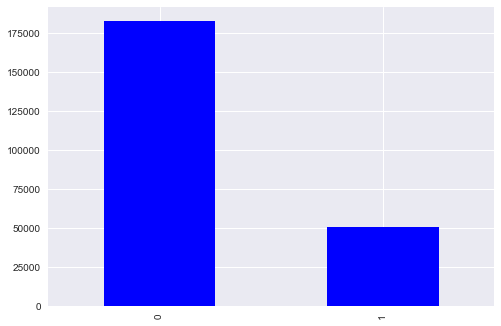

In [8]:
#apply resampling
target_count= train['loan_default'].value_counts()
target_count.plot(kind='bar')
print('0:',target_count[0])
print('1:',target_count[1])
plt.show()

In [9]:
count_0, count_1=train['loan_default'].value_counts()
train_0=train[train['loan_default']==0]
train_1=train[train['loan_default']==1]

In [10]:
# df_under=train_0.sample(count_1)
# df_under=pd.concat([df_under, train_1], axis=0)
# df_under['loan_default'].value_counts()

In [11]:
df_over=train_1.sample(count_0, replace=True)
df_over=pd.concat([df_over,train_0], axis=0)
df_over['loan_default'].value_counts()

1    182543
0    182543
Name: loan_default, dtype: int64

In [12]:
y_over=df_over['loan_default']
x_over=df_over.drop('loan_default', axis=1)
# y_under=df_under['loan_default']
# x_under=df_under.drop('loan_default', axis=1)

In [13]:
x_over.shape

(365086, 29)

In [14]:
#standard scaler on x and test
scaler = StandardScaler()
# Fit on training set only.
scaler.fit(x_over)
# Apply transform to both the training set and the test set.
x_scale= scaler.transform(x_over)
# x_over_scale= scaler.transform(x_over_smote)
test = scaler.transform(test)

/Users/gagicha/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/gagicha/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  
/Users/gagicha/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  


In [15]:
x_scale.shape

(365086, 29)

In [16]:
train_x, test_x, train_y, test_y= train_test_split(x_scale, y_over, test_size=0.33)

In [51]:
model=xgb.XGBClassifier(n_jobs=-1, n_estimators=700)
eval_metric = ["error","logloss",'auc']
eval_set = [(train_x, train_y), (test_x, test_y)]
model.fit(train_x, train_y, eval_metric=eval_metric , eval_set=eval_set)

[0]	validation_0-error:0.422858	validation_0-logloss:0.690066	validation_0-auc:0.598244	validation_1-error:0.422032	validation_1-logloss:0.690023	validation_1-auc:0.599138
[1]	validation_0-error:0.422416	validation_0-logloss:0.687553	validation_0-auc:0.600412	validation_1-error:0.421393	validation_1-logloss:0.687491	validation_1-auc:0.601098
[2]	validation_0-error:0.41756	validation_0-logloss:0.685401	validation_0-auc:0.607348	validation_1-error:0.416546	validation_1-logloss:0.685304	validation_1-auc:0.608258
[3]	validation_0-error:0.421182	validation_0-logloss:0.683572	validation_0-auc:0.609192	validation_1-error:0.420422	validation_1-logloss:0.683439	validation_1-auc:0.610168
[4]	validation_0-error:0.420716	validation_0-logloss:0.682021	validation_0-auc:0.610961	validation_1-error:0.419525	validation_1-logloss:0.681856	validation_1-auc:0.61206
[5]	validation_0-error:0.416493	validation_0-logloss:0.680616	validation_0-auc:0.612647	validation_1-error:0.415774	validation_1-logloss:0.680

[48]	validation_0-error:0.401374	validation_0-logloss:0.664224	validation_0-auc:0.635499	validation_1-error:0.401514	validation_1-logloss:0.664537	validation_1-auc:0.634373
[49]	validation_0-error:0.401268	validation_0-logloss:0.664081	validation_0-auc:0.635779	validation_1-error:0.401331	validation_1-logloss:0.664403	validation_1-auc:0.634607
[50]	validation_0-error:0.401415	validation_0-logloss:0.664002	validation_0-auc:0.635807	validation_1-error:0.401373	validation_1-logloss:0.664338	validation_1-auc:0.634592
[51]	validation_0-error:0.40117	validation_0-logloss:0.663783	validation_0-auc:0.636249	validation_1-error:0.401165	validation_1-logloss:0.664117	validation_1-auc:0.635038
[52]	validation_0-error:0.400863	validation_0-logloss:0.663686	validation_0-auc:0.636506	validation_1-error:0.400842	validation_1-logloss:0.664038	validation_1-auc:0.635213
[53]	validation_0-error:0.400831	validation_0-logloss:0.663591	validation_0-auc:0.636593	validation_1-error:0.400784	validation_1-loglos

[96]	validation_0-error:0.39709	validation_0-logloss:0.660641	validation_0-auc:0.641834	validation_1-error:0.39782	validation_1-logloss:0.661397	validation_1-auc:0.6398
[97]	validation_0-error:0.396996	validation_0-logloss:0.660599	validation_0-auc:0.641941	validation_1-error:0.397538	validation_1-logloss:0.661372	validation_1-auc:0.639882
[98]	validation_0-error:0.396959	validation_0-logloss:0.660542	validation_0-auc:0.642103	validation_1-error:0.397629	validation_1-logloss:0.661328	validation_1-auc:0.639983
[99]	validation_0-error:0.396877	validation_0-logloss:0.660505	validation_0-auc:0.642194	validation_1-error:0.397737	validation_1-logloss:0.661305	validation_1-auc:0.640028
[100]	validation_0-error:0.396886	validation_0-logloss:0.660478	validation_0-auc:0.642227	validation_1-error:0.397721	validation_1-logloss:0.661286	validation_1-auc:0.640047
[101]	validation_0-error:0.396841	validation_0-logloss:0.660449	validation_0-auc:0.642286	validation_1-error:0.397671	validation_1-logloss

[144]	validation_0-error:0.395103	validation_0-logloss:0.658812	validation_0-auc:0.645411	validation_1-error:0.395969	validation_1-logloss:0.660069	validation_1-auc:0.642309
[145]	validation_0-error:0.394776	validation_0-logloss:0.658751	validation_0-auc:0.645532	validation_1-error:0.396036	validation_1-logloss:0.660022	validation_1-auc:0.642399
[146]	validation_0-error:0.394727	validation_0-logloss:0.658737	validation_0-auc:0.645561	validation_1-error:0.395961	validation_1-logloss:0.660011	validation_1-auc:0.64242
[147]	validation_0-error:0.394596	validation_0-logloss:0.658706	validation_0-auc:0.64561	validation_1-error:0.395878	validation_1-logloss:0.659992	validation_1-auc:0.642443
[148]	validation_0-error:0.394441	validation_0-logloss:0.658676	validation_0-auc:0.645656	validation_1-error:0.395936	validation_1-logloss:0.659976	validation_1-auc:0.642469
[149]	validation_0-error:0.394564	validation_0-logloss:0.658635	validation_0-auc:0.645734	validation_1-error:0.395862	validation_1-l

[192]	validation_0-error:0.392875	validation_0-logloss:0.657328	validation_0-auc:0.648252	validation_1-error:0.395164	validation_1-logloss:0.659085	validation_1-auc:0.644198
[193]	validation_0-error:0.392879	validation_0-logloss:0.657308	validation_0-auc:0.648286	validation_1-error:0.395231	validation_1-logloss:0.659069	validation_1-auc:0.644218
[194]	validation_0-error:0.392977	validation_0-logloss:0.657288	validation_0-auc:0.648306	validation_1-error:0.395081	validation_1-logloss:0.659061	validation_1-auc:0.644232
[195]	validation_0-error:0.393067	validation_0-logloss:0.657261	validation_0-auc:0.64836	validation_1-error:0.395206	validation_1-logloss:0.659042	validation_1-auc:0.644266
[196]	validation_0-error:0.393059	validation_0-logloss:0.657253	validation_0-auc:0.648378	validation_1-error:0.395181	validation_1-logloss:0.659037	validation_1-auc:0.644275
[197]	validation_0-error:0.392855	validation_0-logloss:0.657209	validation_0-auc:0.648485	validation_1-error:0.395164	validation_1-

[240]	validation_0-error:0.391624	validation_0-logloss:0.655999	validation_0-auc:0.650809	validation_1-error:0.394035	validation_1-logloss:0.658172	validation_1-auc:0.645843
[241]	validation_0-error:0.391571	validation_0-logloss:0.655976	validation_0-auc:0.650843	validation_1-error:0.394002	validation_1-logloss:0.658157	validation_1-auc:0.645869
[242]	validation_0-error:0.391546	validation_0-logloss:0.655965	validation_0-auc:0.650856	validation_1-error:0.393986	validation_1-logloss:0.658154	validation_1-auc:0.645871
[243]	validation_0-error:0.39153	validation_0-logloss:0.655929	validation_0-auc:0.650919	validation_1-error:0.394044	validation_1-logloss:0.658132	validation_1-auc:0.645904
[244]	validation_0-error:0.391526	validation_0-logloss:0.655902	validation_0-auc:0.650967	validation_1-error:0.394052	validation_1-logloss:0.658119	validation_1-auc:0.645926
[245]	validation_0-error:0.391522	validation_0-logloss:0.655896	validation_0-auc:0.650974	validation_1-error:0.394052	validation_1-

[288]	validation_0-error:0.389654	validation_0-logloss:0.654722	validation_0-auc:0.653255	validation_1-error:0.393637	validation_1-logloss:0.657398	validation_1-auc:0.647343
[289]	validation_0-error:0.389625	validation_0-logloss:0.654701	validation_0-auc:0.653289	validation_1-error:0.393612	validation_1-logloss:0.657384	validation_1-auc:0.64737
[290]	validation_0-error:0.389547	validation_0-logloss:0.654671	validation_0-auc:0.653353	validation_1-error:0.393604	validation_1-logloss:0.657368	validation_1-auc:0.647403
[291]	validation_0-error:0.389416	validation_0-logloss:0.654641	validation_0-auc:0.653414	validation_1-error:0.39367	validation_1-logloss:0.657342	validation_1-auc:0.647459
[292]	validation_0-error:0.389433	validation_0-logloss:0.654608	validation_0-auc:0.653488	validation_1-error:0.393629	validation_1-logloss:0.657324	validation_1-auc:0.64749
[293]	validation_0-error:0.38947	validation_0-logloss:0.654604	validation_0-auc:0.653489	validation_1-error:0.393629	validation_1-log

[336]	validation_0-error:0.388439	validation_0-logloss:0.653576	validation_0-auc:0.655446	validation_1-error:0.39333	validation_1-logloss:0.65672	validation_1-auc:0.648631
[337]	validation_0-error:0.388452	validation_0-logloss:0.653556	validation_0-auc:0.655469	validation_1-error:0.39333	validation_1-logloss:0.656711	validation_1-auc:0.648641
[338]	validation_0-error:0.38839	validation_0-logloss:0.653541	validation_0-auc:0.655494	validation_1-error:0.393305	validation_1-logloss:0.656705	validation_1-auc:0.648651
[339]	validation_0-error:0.388333	validation_0-logloss:0.65352	validation_0-auc:0.655531	validation_1-error:0.393264	validation_1-logloss:0.6567	validation_1-auc:0.648661
[340]	validation_0-error:0.388333	validation_0-logloss:0.653514	validation_0-auc:0.655537	validation_1-error:0.393272	validation_1-logloss:0.656696	validation_1-auc:0.648663
[341]	validation_0-error:0.388374	validation_0-logloss:0.653489	validation_0-auc:0.655577	validation_1-error:0.393297	validation_1-loglos

[384]	validation_0-error:0.387176	validation_0-logloss:0.652467	validation_0-auc:0.657408	validation_1-error:0.392674	validation_1-logloss:0.656043	validation_1-auc:0.649792
[385]	validation_0-error:0.387098	validation_0-logloss:0.652442	validation_0-auc:0.65747	validation_1-error:0.392674	validation_1-logloss:0.65603	validation_1-auc:0.649823
[386]	validation_0-error:0.387025	validation_0-logloss:0.652413	validation_0-auc:0.657525	validation_1-error:0.392658	validation_1-logloss:0.656023	validation_1-auc:0.64984
[387]	validation_0-error:0.38698	validation_0-logloss:0.652387	validation_0-auc:0.65756	validation_1-error:0.392699	validation_1-logloss:0.65601	validation_1-auc:0.649844
[388]	validation_0-error:0.386939	validation_0-logloss:0.652367	validation_0-auc:0.657604	validation_1-error:0.392633	validation_1-logloss:0.656001	validation_1-auc:0.64987
[389]	validation_0-error:0.386927	validation_0-logloss:0.652337	validation_0-auc:0.657645	validation_1-error:0.392608	validation_1-loglos

[432]	validation_0-error:0.385766	validation_0-logloss:0.651431	validation_0-auc:0.659376	validation_1-error:0.392483	validation_1-logloss:0.655436	validation_1-auc:0.65093
[433]	validation_0-error:0.3857	validation_0-logloss:0.651411	validation_0-auc:0.659419	validation_1-error:0.392425	validation_1-logloss:0.655425	validation_1-auc:0.650949
[434]	validation_0-error:0.38557	validation_0-logloss:0.651366	validation_0-auc:0.659521	validation_1-error:0.392375	validation_1-logloss:0.655386	validation_1-auc:0.65104
[435]	validation_0-error:0.385443	validation_0-logloss:0.65134	validation_0-auc:0.659569	validation_1-error:0.392234	validation_1-logloss:0.655372	validation_1-auc:0.651063
[436]	validation_0-error:0.385435	validation_0-logloss:0.651325	validation_0-auc:0.659596	validation_1-error:0.392243	validation_1-logloss:0.655359	validation_1-auc:0.651085
[437]	validation_0-error:0.385418	validation_0-logloss:0.651303	validation_0-auc:0.65966	validation_1-error:0.392218	validation_1-loglos

[480]	validation_0-error:0.384274	validation_0-logloss:0.650487	validation_0-auc:0.661131	validation_1-error:0.391579	validation_1-logloss:0.654851	validation_1-auc:0.651998
[481]	validation_0-error:0.38418	validation_0-logloss:0.65046	validation_0-auc:0.661184	validation_1-error:0.391587	validation_1-logloss:0.654834	validation_1-auc:0.65203
[482]	validation_0-error:0.384086	validation_0-logloss:0.650425	validation_0-auc:0.661266	validation_1-error:0.391471	validation_1-logloss:0.654818	validation_1-auc:0.65207
[483]	validation_0-error:0.384077	validation_0-logloss:0.650397	validation_0-auc:0.661311	validation_1-error:0.39157	validation_1-logloss:0.654804	validation_1-auc:0.652095
[484]	validation_0-error:0.38413	validation_0-logloss:0.650372	validation_0-auc:0.66134	validation_1-error:0.39162	validation_1-logloss:0.654784	validation_1-auc:0.652111
[485]	validation_0-error:0.384057	validation_0-logloss:0.65034	validation_0-auc:0.661405	validation_1-error:0.391537	validation_1-logloss:

[528]	validation_0-error:0.382912	validation_0-logloss:0.64949	validation_0-auc:0.662871	validation_1-error:0.390749	validation_1-logloss:0.654277	validation_1-auc:0.652912
[529]	validation_0-error:0.382912	validation_0-logloss:0.649484	validation_0-auc:0.662883	validation_1-error:0.390757	validation_1-logloss:0.654276	validation_1-auc:0.652914
[530]	validation_0-error:0.382912	validation_0-logloss:0.64947	validation_0-auc:0.662899	validation_1-error:0.390774	validation_1-logloss:0.654265	validation_1-auc:0.652922
[531]	validation_0-error:0.3829	validation_0-logloss:0.649465	validation_0-auc:0.662905	validation_1-error:0.390765	validation_1-logloss:0.654263	validation_1-auc:0.652929
[532]	validation_0-error:0.382892	validation_0-logloss:0.649447	validation_0-auc:0.66295	validation_1-error:0.390798	validation_1-logloss:0.654254	validation_1-auc:0.652944
[533]	validation_0-error:0.382941	validation_0-logloss:0.649415	validation_0-auc:0.662999	validation_1-error:0.390798	validation_1-logl

[576]	validation_0-error:0.382172	validation_0-logloss:0.648499	validation_0-auc:0.664593	validation_1-error:0.390599	validation_1-logloss:0.653758	validation_1-auc:0.653779
[577]	validation_0-error:0.382131	validation_0-logloss:0.648479	validation_0-auc:0.664649	validation_1-error:0.390574	validation_1-logloss:0.653749	validation_1-auc:0.653798
[578]	validation_0-error:0.382127	validation_0-logloss:0.648466	validation_0-auc:0.664667	validation_1-error:0.390566	validation_1-logloss:0.653743	validation_1-auc:0.6538
[579]	validation_0-error:0.381972	validation_0-logloss:0.648431	validation_0-auc:0.664744	validation_1-error:0.390549	validation_1-logloss:0.653733	validation_1-auc:0.653821
[580]	validation_0-error:0.381972	validation_0-logloss:0.648418	validation_0-auc:0.664766	validation_1-error:0.390541	validation_1-logloss:0.653718	validation_1-auc:0.65385
[581]	validation_0-error:0.381956	validation_0-logloss:0.648394	validation_0-auc:0.664815	validation_1-error:0.39045	validation_1-log

[624]	validation_0-error:0.380516	validation_0-logloss:0.647502	validation_0-auc:0.666572	validation_1-error:0.38918	validation_1-logloss:0.653205	validation_1-auc:0.654823
[625]	validation_0-error:0.380373	validation_0-logloss:0.647471	validation_0-auc:0.666638	validation_1-error:0.389188	validation_1-logloss:0.65318	validation_1-auc:0.654877
[626]	validation_0-error:0.380324	validation_0-logloss:0.647445	validation_0-auc:0.666693	validation_1-error:0.389113	validation_1-logloss:0.653158	validation_1-auc:0.654927
[627]	validation_0-error:0.380308	validation_0-logloss:0.64743	validation_0-auc:0.666722	validation_1-error:0.389089	validation_1-logloss:0.653151	validation_1-auc:0.654938
[628]	validation_0-error:0.380296	validation_0-logloss:0.647425	validation_0-auc:0.66673	validation_1-error:0.389089	validation_1-logloss:0.653149	validation_1-auc:0.65494
[629]	validation_0-error:0.380296	validation_0-logloss:0.647422	validation_0-auc:0.666735	validation_1-error:0.389089	validation_1-logl

[672]	validation_0-error:0.379462	validation_0-logloss:0.646699	validation_0-auc:0.667986	validation_1-error:0.388607	validation_1-logloss:0.652718	validation_1-auc:0.655639
[673]	validation_0-error:0.379413	validation_0-logloss:0.64668	validation_0-auc:0.668003	validation_1-error:0.388566	validation_1-logloss:0.652697	validation_1-auc:0.655664
[674]	validation_0-error:0.379433	validation_0-logloss:0.646659	validation_0-auc:0.668029	validation_1-error:0.388516	validation_1-logloss:0.652685	validation_1-auc:0.655677
[675]	validation_0-error:0.379437	validation_0-logloss:0.64664	validation_0-auc:0.668061	validation_1-error:0.388615	validation_1-logloss:0.652675	validation_1-auc:0.655692
[676]	validation_0-error:0.379405	validation_0-logloss:0.646622	validation_0-auc:0.668095	validation_1-error:0.388599	validation_1-logloss:0.65266	validation_1-auc:0.655721
[677]	validation_0-error:0.379396	validation_0-logloss:0.646612	validation_0-auc:0.668115	validation_1-error:0.388541	validation_1-lo

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=700,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

In [53]:
results=model.evals_result()

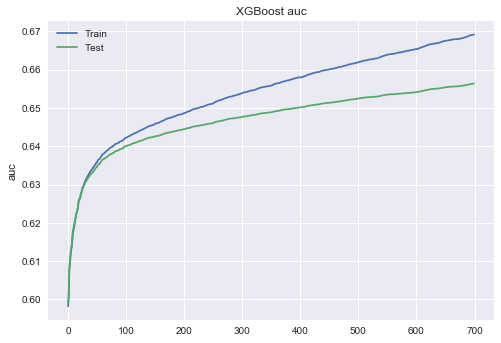

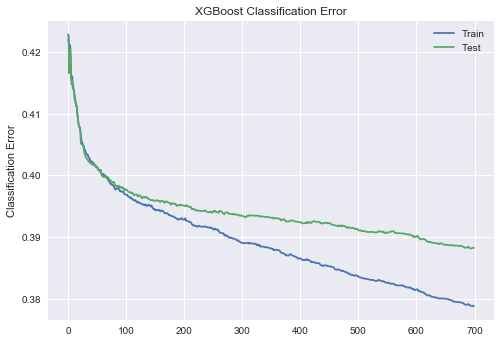

In [56]:
epochs=len(results['validation_0']['error'])
x_axis = range(0, epochs)
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['auc'], label='Train')
ax.plot(x_axis, results['validation_1']['auc'], label='Test')
ax.legend()
pyplot.ylabel('auc')
pyplot.title('XGBoost auc')
pyplot.show()
# plot classification error
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
pyplot.ylabel('Classification Error')
pyplot.title('XGBoost Classification Error')
pyplot.show()

after 100 epochs, the accuracy is noot increasing much. so let n_iterations=150

In [65]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier(learning_rate =0.1, n_estimators=100, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(x_scale, y_over)
# gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.8),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'max_depth': range(3, 10, 2), 'min_child_weight': range(1, 6, 2)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [66]:
gsearch1.best_params_

{'max_depth': 9, 'min_child_weight': 1}

In [74]:
xgb_model=xgb.XGBClassifier(n_estimators=150, max_depth=9, n_jobs=-1,min_child_weight=1,learning_rate=0.1 )
eval_set = [(train_x, train_y), (test_x, test_y)]
xgb_model.fit(train_x, train_y, eval_metric='auc',eval_set=eval_set)

[0]	validation_0-auc:0.651543	validation_1-auc:0.637951
[1]	validation_0-auc:0.659315	validation_1-auc:0.643703
[2]	validation_0-auc:0.667879	validation_1-auc:0.650036
[3]	validation_0-auc:0.672876	validation_1-auc:0.653514
[4]	validation_0-auc:0.675562	validation_1-auc:0.655866
[5]	validation_0-auc:0.677658	validation_1-auc:0.657349
[6]	validation_0-auc:0.680606	validation_1-auc:0.659535
[7]	validation_0-auc:0.68326	validation_1-auc:0.661501
[8]	validation_0-auc:0.68536	validation_1-auc:0.662798
[9]	validation_0-auc:0.687488	validation_1-auc:0.664183
[10]	validation_0-auc:0.689647	validation_1-auc:0.665554
[11]	validation_0-auc:0.691929	validation_1-auc:0.667175
[12]	validation_0-auc:0.693689	validation_1-auc:0.668124
[13]	validation_0-auc:0.696032	validation_1-auc:0.669906
[14]	validation_0-auc:0.698012	validation_1-auc:0.671157
[15]	validation_0-auc:0.700088	validation_1-auc:0.672469
[16]	validation_0-auc:0.70183	validation_1-auc:0.673633
[17]	validation_0-auc:0.703574	validation_1-

[144]	validation_0-auc:0.775122	validation_1-auc:0.719887
[145]	validation_0-auc:0.775262	validation_1-auc:0.719985
[146]	validation_0-auc:0.775284	validation_1-auc:0.720002
[147]	validation_0-auc:0.77531	validation_1-auc:0.720019
[148]	validation_0-auc:0.776523	validation_1-auc:0.720746
[149]	validation_0-auc:0.77762	validation_1-auc:0.721407


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=9, min_child_weight=1, missing=None, n_estimators=150,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

In [75]:
print('acc: ',xgb_model.score(test_x, test_y))
pred_xgb= xgb_model.predict(test_x)
print('auc: ',metrics.roc_auc_score(test_y, pred_xgb))
print(metrics.confusion_matrix(test_y, pred_xgb))

acc:  0.6559151387378713
auc:  0.6558354095990276
[[35728 24434]
 [17021 43296]]


In [76]:
out=pd.concat([df_test['UniqueID'], pd.DataFrame(xgb_model.predict(test),columns=['loan_default'])], axis=1)

In [77]:
out.head(15)

,UniqueID,loan_default
0,655269,1
1,723482,0
2,758529,1
3,763449,0
4,708663,1
5,725530,1
6,708592,1
7,714975,0
8,712795,1
9,708656,1


In [78]:
out.to_csv('loan_predict.csv', encoding='utf-8', index=False)